<a href="https://colab.research.google.com/github/Kim-JungHyun01/AIStudy24/blob/master/%EB%94%A5%EB%9F%AC%EB%8B%9D/LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 GRU 셀
- 순환신경망에서 빼 놓을 수 없는 핵심 기술
- simpleRNN 보다 훨씬 복잡하지만 성능이 뛰어나기 때문에
- 긴 시퀀스의 경우
    - 기본 순환층
        - 학습하기 어려움(이전의 토큰이 날라감)
        - 시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석됨(멀리 떨어진 단어 인식 어려움)
    - LSTM과 GRU
        - 멀리 떨어져 있는 단어 정보를 인식시키기 위해 사용

# LSTM(Long Short-Term Memory)
- RNN 단기 기억을 오래 기억하기 위해 고안된 구조
- 기본개념은 동일
    - 입력과 가중치를 곱하고 절편을 더해 활성함수를 통과시키는 구조를 여러개 가짐
    - 이럼 계산 결과를 타임스템에 재사용(순환)
- 순환구조 종류
    1. 은닉상태(hidden)로 만드는 방법
        - 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한후 활성화 함수를 통과시켜 다음 은닉상태로 만듬
        - 이때 스그모이드 활성화 함수이용
        - 또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듬

    2. 셀상태(아래그림참고)

<img src="https://velog.velcdn.com/images/2kimjh/post/dd25b8e3-aac6-41a4-8a87-bca5039535d6/image.png" width=500px>

- 가중치(w_o) : w_x, w_h 통들어서 표현
- 활성화함수
    - tanh함수 : 파란색원
    - 스그모이드 함수 : 주황색원
- x : 곱셈(기본 순환층과 크게 다르지 않음)


- tanh 함수를 통과한 값은?
    - LSTM에는 순환되는 상태가 2개이다.
        1. 은닉상태 : 숨어있는 것
        1. 셀상태 : 표현에 나타나있는 것
    - 은닉상태와 달리 셀상태는 다음 층으로 전달되지 않고, LSTM 셀에서 순환만 되는 값

<img src="https://velog.velcdn.com/images/2kimjh/post/98c9dedd-8c84-46cb-b382-d1de70113615/image.png" width=500px>

- 순환되는 셀의 상태(c) : 녹색화살표
- h : 은닉상태

2. 셀 상태를 만드는 과정
    - 입력과 은닉상태를 또 가중치 w_f에 곱한 다음 시그모이드 함수를 통과함
    - 그다음 이전 타임스탭의 셀 상태와 곱하여 새로운 셀의 상태를 만듬
    - 이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉상태를 만드는 데 기여함
    - LSTM은 마치 작은 셀을 여러개 포함하고 있는 큰 셀 같다.
    - 중료한 것은 입력과 은닉상태에서 곱해지는 가중치 w_o와 w_f가 다름
     
    => 이 두 작은 셀은 각기 다른 기능을 위해 훈련

- 여거에 2개의 작은 셀이 더 추가되어 셀의 상태를 만드는데 기여함

<img src="https://velog.velcdn.com/images/2kimjh/post/378d2e67-becf-455a-96e4-8c1d335e03f5/image.png" width=600px>

- 이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음 하나의 시그모이드 함수를 통과
- 다른 하나는 tanh 함수를 통과
- 그 다음 두 결과를 곱한 후 이전 셀의 상태와 더함(최종상태의 셀)

<img src="https://velog.velcdn.com/images/2kimjh/post/67117c2b-a668-4034-91fb-f4c980fa3acc/image.png" width=500px>

- 다음과 같은 처리는 keras의 LSTM클래스가 알아서 처리
- 게이트
    - 입력게이트(input gate) : 새로운 정보를 셀 상태에 추가
    - 출력게이트(output gate) : 셀 상태가 다음 은닉상태로 출력
    - 삭제게이트(forget gate) : 셀의 상태에 있는 정보를 제거하는 역활

# LSTM 훈련실습

## 데이터

In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
print(train_input.shape, val_input.shape ,test_input.shape)
#           (20000,)         (5000,)           (25000,)

(20000,) (5000,) (25000,)


## 데이터 전처리

### 시퀸스 길이조절(pad_sequences())
- 각 샘플의 길이를 100에 맞추고 부족할 때 패딩을 추가

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# truncating = 'pre' : 기본값(생략가능)
train_seq = pad_sequences(train_input, maxlen = 100)
val_seq = pad_sequences(val_input, maxlen = 100)

print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


## LSTM 신경망 생성
- 단어인베딩 이용(keras.layers.Embedding)

In [6]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_shape=(100,))) #단어 인베딩
                    # num_words = 500(단어사전크기)
                        # 임베딩백터크기 = 16
                                            # maxlen = 100

model.add(keras.layers.LSTM(8)) #뉴런갯수 8
model.add(keras.layers.Dense(1, activation='sigmoid')) # 2진분류 : 시그모이드함수

model.summary()
# simpleRNN 클래스의 모델 파라미터 개수는 200개
# LSTM 셀에는 작은 셀이 4개 있으므로 정확히 800개 : 4 * 200 = 800

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

### 모델요약
임베딩 층은 (100,)을 받아 (100, 16) 크기의 출력을 만듬
- 파라미터개수
    1. Emvedding층
        - 500개의 토큰을 받아 각 토큰의 크기를 16인 벡터로 변경
        - 계산 : 500 * 16 = 8000의 모델 파라미터를 가짐
    2. LSTM층    
        - 계산식 : 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
            - 계산 : 4 * ((16 + 1) * 8 + 8^2) = 800
    3. 출력층
        - 8 * 1 + 1 = 9

## LSTM 훈련(model)

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4) #학습률 0.0001 지수표현

model.compile(optimizer=rmsprop, loss = 'binary_crossentropy', metrics=['accuracy']) #이진분류

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True) # 최상을 점수로 저장

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #조기종료 3번 인내심

#에포크 100, 배치크기 64 : 몇개의 샘플로 가중치를 갱신할 것인지 설정
history = model.fit(train_seq, train_target, epochs = 100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 체크포인트 조기종료

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.5864 - val_loss: 0.6911
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5784 - loss: 0.6907 - val_accuracy: 0.6258 - val_loss: 0.6874
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6217 - loss: 0.6858 - val_accuracy: 0.6562 - val_loss: 0.6765
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.6681 - loss: 0.6682 - val_accuracy: 0.7096 - val_loss: 0.6177
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7180 - loss: 0.6006 - val_accuracy: 0.7248 - val_loss: 0.5760
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.7282 - loss: 0.5690 - val_accuracy: 0.7404 - val_loss: 0.5555
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7481 - loss: 0.5465 - val_accuracy: 0.7450 - val_loss: 0.5383
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7600 - loss: 0

### 훈련평가

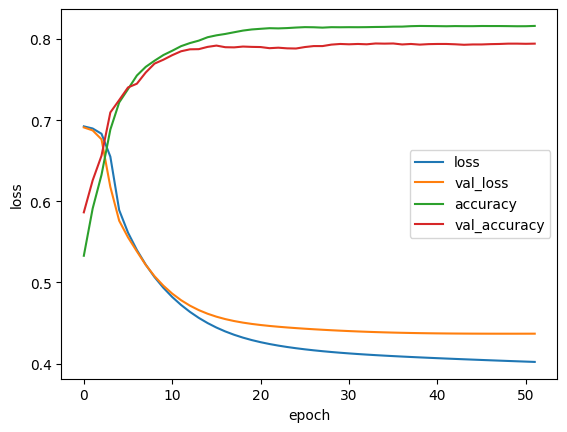

In [10]:
# 에포크 52, 정확도 81.67%

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()

## 결론
- 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행하는 것처럼 보임
- 하지만 경우에 따라 과대 적합을 더 강하게 제어할 필요가 있음
- 결론 : **드룹아웃**이용

## LSTM 신경망 재생성(드룹아웃이용)
- Dropout
    - 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 훈련세트의 과대적합 방지
    1. 완전 연결 신경망과 합성곱 신경망 : Dropout 클래스를 사용하여 적용
    2. 순환층 : 자체적인 드룹아웃 기능 존재
- 매개변수
    - simpleRNN과 LSTM 클래스 모두 매개변수 포함
    - dropout
        - 셀의 입력에 드롭아웃을 적용
    - resurrent_dropout
        - 순환은닉 상태에 드룹아웃을 적용함
        - 이용시 GPU를 사용하여 모델을 훈련하지 못함(모델 훈련속도가 크게 느려짐)
            - 그래서 dropout만 적용해 볼것

In [11]:
from tensorflow import keras

model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape=(100,))) #단어 인베딩
model2.add(keras.layers.LSTM(8, dropout=0.3)) #뉴런갯수 8, 드룹아웃 : 30%
model2.add(keras.layers.Dense(1, activation='sigmoid')) # 2진분류 : 시그모이드함수

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

## LSTM 재훈련(model2)

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4) #학습률 0.0001 지수표현

model2.compile(optimizer=rmsprop, loss = 'binary_crossentropy', metrics=['accuracy']) #이진분류

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', save_best_only=True) # 최상을 점수로 저장

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #조기종료 3번 인내심

#에포크 100, 배치크기 64 : 몇개의 샘플로 가중치를 갱신할 것인지 설정
history = model2.fit(train_seq, train_target, epochs = 100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 체크포인트 조기종료

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.5145 - loss: 0.6930 - val_accuracy: 0.5716 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.5619 - loss: 0.6920 - val_accuracy: 0.6068 - val_loss: 0.6908
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6025 - loss: 0.6902 - val_accuracy: 0.6288 - val_loss: 0.6879
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6257 - loss: 0.6865 - val_accuracy: 0.6490 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.6458 - loss: 0.6773 - val_accuracy: 0.6560 - val_loss: 0.6494
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.6848 - loss: 0.6394 - val_accuracy: 0.7270 - val_loss: 0.5991
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7198 - loss: 0.5997 - val_accuracy: 0.7404 - val_loss: 0.5803
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.7326 - loss: 0

### 훈련평가

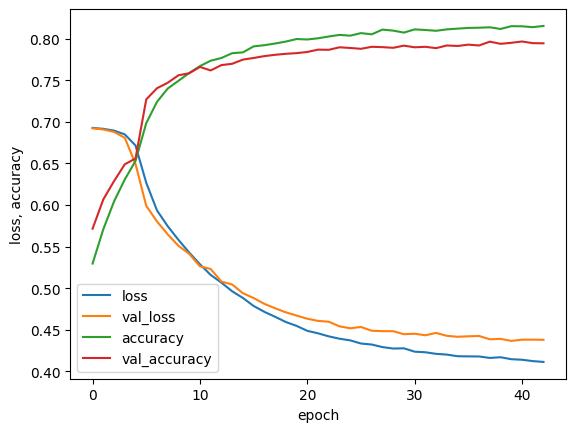

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()
# 그래프가 흔들리는 이유 : Dropout 적용으로 인한 변화

In [ ]:
# 전      : 에포크 52, accuracy: 0.8167, 손실류차 : loss: 0.4013 - val_loss: 0.4368 => 0.0355
# dropout : 에포크 43, accuracy: 81.67%, 손실류차 : loss: 0.4109 - val_loss: 0.4381 => 0.0272

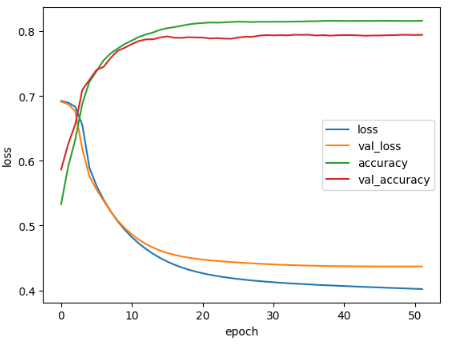

# 순환층 연결
- 2개의 순환층 연결
- 주의점
    -

- 순환층을 연결할 때는 한가지 주의점
    - 숨환층의 은닉 상태는 샘플의 마지막 타임스탭에 대한 은닉상태만 다음층으로 전달됨
- 하지만 순환층을 쌓게되면 모든 순환층에 순차 데이터가 필요
- 앞쪽의 순환층이 모든 타임스텝에 대한 은닉상태를 출력하야함
- 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야한다.

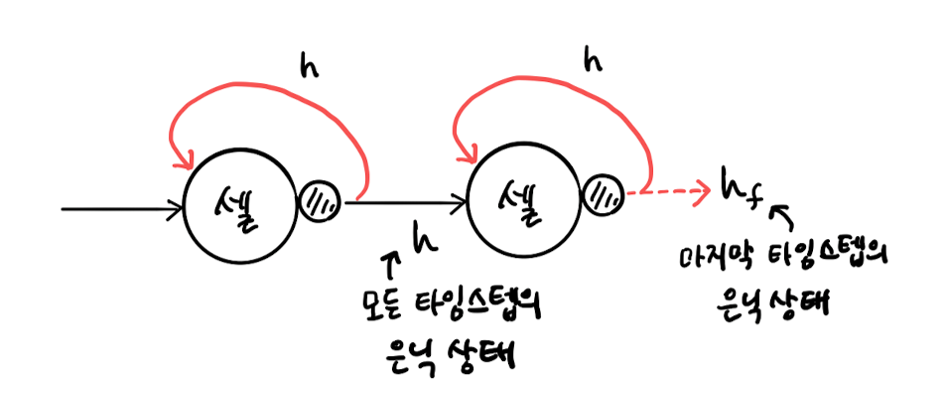

## LSTM 신경명 재생성(순환층연결)

In [14]:
# 케라스 순환층에서 모든 타임스텝읜 은닉상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences=True로 지정

from tensorflow import keras

model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape=(100,))) #단어 인베딩
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True)) #첫번째 LSTM
model3.add(keras.layers.LSTM(8, dropout=0.3))                        #두번째 LSTM
model3.add(keras.layers.Dense(1, activation='sigmoid')) # 2진분류 : 시그모이드함수

model3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

### 모델분석(model3)
- 첫번째 LSTM 층이 모든 타임스텝(100개)의 은닉상태를 출력하기 때문에 출력 크기가 (None, 100, 8)로 표시됨
- 이에 반해 두번째 LSTM 층의 출력 크기는 마지막 타임 스텝의 은닉상태만 출력하기 때문에 (None, 8)이다

## LSTM 재훈련(model3)

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4) #학습률 0.0001 지수표현

model3.compile(optimizer=rmsprop, loss = 'binary_crossentropy', metrics=['accuracy']) #이진분류

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', save_best_only=True) # 최상을 점수로 저장

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #조기종료 3번 인내심

#에포크 100, 배치크기 64 : 몇개의 샘플로 가중치를 갱신할 것인지 설정
history = model3.fit(train_seq, train_target, epochs = 100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 체크포인트 조기종료

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - accuracy: 0.5235 - loss: 0.6927 - val_accuracy: 0.5964 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.5854 - loss: 0.6888 - val_accuracy: 0.6470 - val_loss: 0.6764
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 102ms/step - accuracy: 0.6495 - loss: 0.6604 - val_accuracy: 0.7104 - val_loss: 0.5774
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.7134 - loss: 0.5717 - val_accuracy: 0.7346 - val_loss: 0.5318
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.7405 - loss: 0.5346 - val_accuracy: 0.7580 - val_loss: 0.5051
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.7571 - loss: 0.5090 - val_accuracy: 0.7616 - val_loss: 0.4972
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.7712 - loss: 0.4930 - val_accuracy: 0.7654 - val_loss: 0.4921
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7732 - loss: 

### 훈련평가

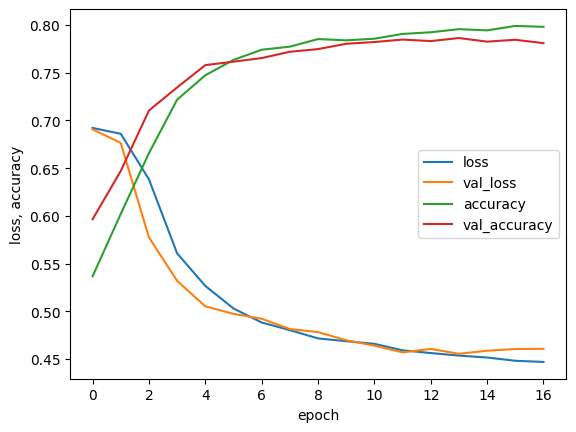

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()
# 과대적합을 제어하면서 손실을 최대한 낮춘느낌
# 층을 추가하고 return_sequences로 진행

In [ ]:
# 전         : 에포크 52, accuracy: 0.8167, 손실류차 : loss: 0.4013 - val_loss: 0.4368 => 0.0355
# dropout    : 에포크 43, accuracy: 81.67%, 손실류차 : loss: 0.4109 - val_loss: 0.4381 => 0.0272
# 순환층연결 : 에포크 17, accuracy: 79.82%, 손실류차 : loss: 0.4452 - val_loss: 0.4606 => 0.0154

# GRU(Gated Recurrent Units)
- LSTM 간소화 버전
- 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있음
- GRU 셀
    - 은닉상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다.
        - 2개 : 시그모이드 활성화함수를 사용
        - 1개 : tanh 활성화 함수 사용
        - 여기에도 은닉 상태와 곱해지는 가중치를 합쳐서 나타냈음
    - LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM과 비슷한 성능을 낸다.

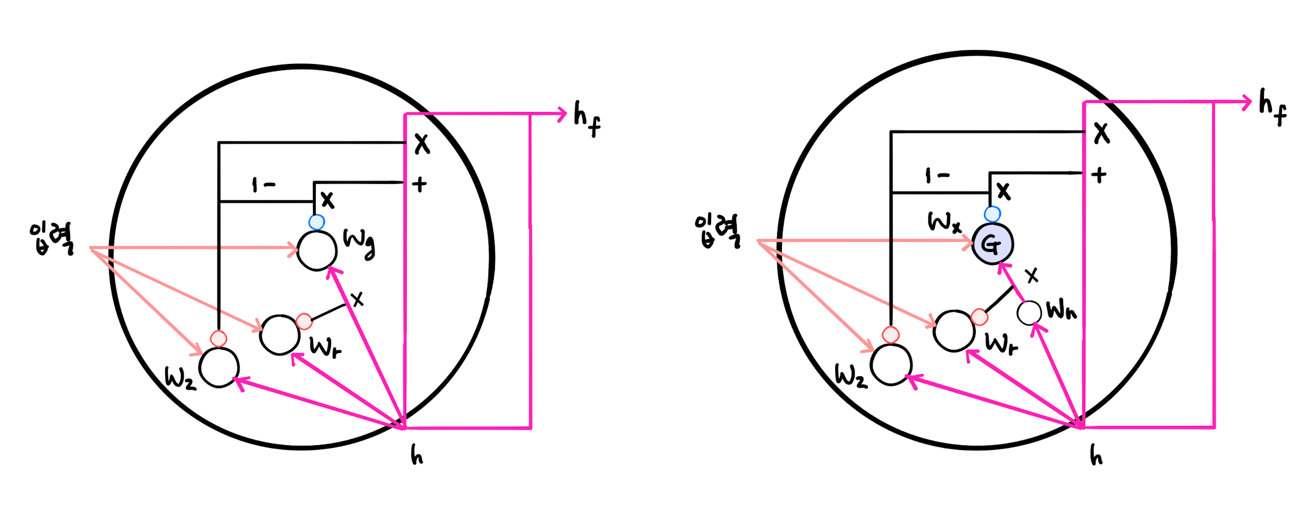

- 셀작동방식
    - w_z : 사용하는 셀(w_z)의 출력이 은닉상태에서 바로 곱해짐 = 삭제게이트
    - w_g : w_z의 출력을 1에서 뺀 다음에 사용하는 셀의 출력(w_g)에 곱함 = 입력되는 정보를 제어하는 역활(controller)
    - w_r : w_g의 출력셀이 사용할 은닉상태의 정보를 제어
---
- 맨 왼쪽 w_z를 사용하는 셀의 출력이 은닉 상태에서 바로 곱해져 삭제 게이트 역활을 수행한다.
- 이와 똑같은 출력은 1에서 뺀 다음에 가장 오른쪽 w_g를 사용하는 셀의 출력에 곱한다.
    - 이를 입력되는 정보를 제어하는 역할을 수행한다.
- 가운데 w_r을 사용하는 셀에서는 출력된 w_g셀이 사용할 은닉 상태의 정보를 제어한다.

## LSTM 신경망 재생성(GRU 이용)

In [18]:
from tensorflow import keras

model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_shape=(100,))) #단어 인베딩
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid')) # 2진분류 : 시그모이드함수

model4.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

### 모델분석(moel4)
- GRU셀에는 3개의 작은 셀존재
    - 작은셀 : 인력과 은닉상태에 곱하는 가중치와 절편존재
        - 셀의 갯수 : 3
        - 입력 가중치 : 16 * 8 = 128
        - 은닉상태 가중치 : 8 * 8 = 64
        - 절편 : 8
    - 계산 : (128 + 64 + 1) * 3 = 200 * 3 = 600

    - 624개가 된 이유 : 3개의 절편마다 8개의 뉴런까지 존재 : 3 * 8 = 24
        - 총계산 : 600 + 24 = 624
- 텐스플로가 이런 계산방식ㅇ르 사용하는 이유는 GPU를 잘 활용하기 위해서 (LSTM 개선점)

## LSTM 재훈련(model4)

In [19]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4) #학습률 0.0001 지수표현

model4.compile(optimizer=rmsprop, loss = 'binary_crossentropy', metrics=['accuracy']) #이진분류

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gpu-model.keras', save_best_only=True) # 최상을 점수로 저장

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #조기종료 3번 인내심

#에포크 100, 배치크기 64 : 몇개의 샘플로 가중치를 갱신할 것인지 설정
history = model4.fit(train_seq, train_target, epochs = 100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 체크포인트 조기종료

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5113 - loss: 0.6929 - val_accuracy: 0.5220 - val_loss: 0.6924
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.5423 - loss: 0.6916 - val_accuracy: 0.5396 - val_loss: 0.6910
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.5569 - loss: 0.6899 - val_accuracy: 0.5490 - val_loss: 0.6891
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.5705 - loss: 0.6875 - val_accuracy: 0.5586 - val_loss: 0.6863
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.5871 - loss: 0.6841 - val_accuracy: 0.5760 - val_loss: 0.6823
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.6017 - loss: 0.6792 - val_accuracy: 0.5876 - val_loss: 0.6767
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.6124 - loss: 0.6723 - val_accuracy: 0.6030 - val_loss: 0.6689
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.6241 - loss: 0

### 훈련평가

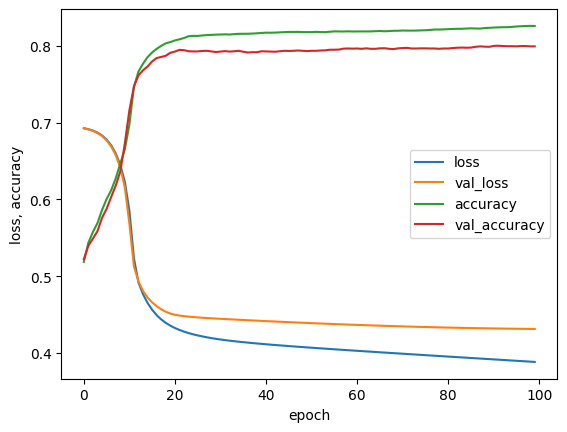

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# 전         : 에포크 52,  accuracy: 81.67%, 손실류차 : loss: 0.4013 - val_loss: 0.4368 => 0.0355
# dropout    : 에포크 43,  accuracy: 81.67%, 손실류차 : loss: 0.4109 - val_loss: 0.4381 => 0.0272
# 순환층연결 : 에포크 17,  accuracy: 79.82%, 손실류차 : loss: 0.4452 - val_loss: 0.4606 => 0.0154
# GPU1       : 에포크 100, accuracy: 82.56%, 손실류차 : loss: 0.3867 - val_loss: 0.4313 => 0.0446

## LSTM 신경망 재생성(GRU이용)_2

In [21]:
# 케라스 순환층에서 모든 타임스텝읜 은닉상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences=True로 지정

from tensorflow import keras

model5 = keras.Sequential()

model5.add(keras.layers.Embedding(500, 16, input_shape=(100,))) #단어 인베딩
model5.add(keras.layers.GRU(8, dropout=0.3, return_sequences=True)) #첫번째 GRU
model5.add(keras.layers.GRU(8, dropout=0.3))                        #두번째 GRU
model5.add(keras.layers.Dense(1, activation='sigmoid')) # 2진분류 : 시그모이드함수

model5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 100, 8)              │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 8)                   │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,065 (35.41 KB)

 Trainable params: 9,065 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4) #학습률 0.0001 지수표현

model5.compile(optimizer=rmsprop, loss = 'binary_crossentropy', metrics=['accuracy']) #이진분류

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gpu2-model.keras', save_best_only=True) # 최상을 점수로 저장

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #조기종료 3번 인내심

#에포크 100, 배치크기 64 : 몇개의 샘플로 가중치를 갱신할 것인지 설정
history = model5.fit(train_seq, train_target, epochs = 100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb]) # 체크포인트 조기종료

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.5053 - loss: 0.6931 - val_accuracy: 0.5166 - val_loss: 0.6926
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.5338 - loss: 0.6922 - val_accuracy: 0.5746 - val_loss: 0.6912
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.5529 - loss: 0.6908 - val_accuracy: 0.5988 - val_loss: 0.6893
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5688 - loss: 0.6884 - val_accuracy: 0.6042 - val_loss: 0.6862
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.5918 - loss: 0.6843 - val_accuracy: 0.6122 - val_loss: 0.6807
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.6087 - loss: 0.6784 - val_accuracy: 0.6184 - val_loss: 0.6723
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.6198 - loss: 0.6688 - val_accuracy: 0.6312 - val_loss: 0.6597
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - accuracy: 0.6307 -

### 훈련평가

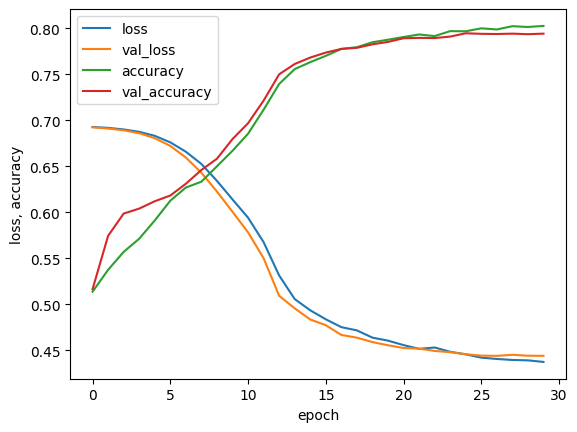

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss, accuracy')
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# 전         : 에포크 52,  accuracy: 81.67%, 손실류차 : loss: 0.4013 - val_loss: 0.4368 => 0.0355 : 16분
# dropout    : 에포크 43,  accuracy: 81.67%, 손실류차 : loss: 0.4109 - val_loss: 0.4381 => 0.0272 : 13분
# 순환층연결 : 에포크 17,  accuracy: 79.82%, 손실류차 : loss: 0.4452 - val_loss: 0.4606 => 0.0154 : 10분
# GPU1       : 에포크 100, accuracy: 82.56%, 손실류차 : loss: 0.3867 - val_loss: 0.4313 => 0.0446 : 35분
# GPU2       : 에포크 30,  accuracy: 80.15%, 손실류차 : loss: 0.4398 - val_loss: 0.4441 => 0.0043 : 19분

# LSTM 최종평가(evaluate)

In [33]:
test_seq = pad_sequences(test_input, maxlen=100)

In [34]:
lstm_model = keras.models.load_model('best-lstm-model.keras')
rnn_model = keras.models.load_model('best-2rnn-model.keras')
dropout_model = keras.models.load_model('best-dropout-model.keras')
gpu_model = keras.models.load_model('best-gpu-model.keras')
gpu2_model = keras.models.load_model('best-gpu2-model.keras')

In [35]:
print("모델 : LSTM", lstm_model.evaluate(test_seq, test_target))
print("모델 : 순환층연결", rnn_model.evaluate(test_seq, test_target))
print("모델 : 드룹 아웃", dropout_model.evaluate(test_seq, test_target))
print("모델 : GRU", gpu_model.evaluate(test_seq, test_target))
print("모델 : GRU2", gpu2_model.evaluate(test_seq, test_target))

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8005 - loss: 0.4325
모델 : LSTM [0.4330812990665436, 0.7997199892997742]
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.7877 - loss: 0.4545
모델 : 순환층연결 [0.45431801676750183, 0.7878400087356567]
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8024 - loss: 0.4356
모델 : 드룹 아웃 [0.43517425656318665, 0.8009999990463257]
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8059 - loss: 0.4282
모델 : GRU [0.42775389552116394, 0.8044400215148926]
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.7967 - loss: 0.4437
모델 : GRU2 [0.44304007291793823, 0.7957199811935425]


In [ ]:
# 모델명      loss    accuracy    traintime
# LSTM       0.4331,    79.97%      16분
# 순환층연결 0.4543,    78.78%      13분
# 드룹 아웃  0.4352,    80.10%      10분
# GRU        0.4278,    80.44%      35분
# GRU2       0.4430,    79.57%      19분